In [1]:
import torch
import torch.nn as nn

In [2]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]

        return output

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [4]:
np.unique(plt.imread('SS_Self_driving_Cars/dataA/dataA/CameraSeg/02_00_220.png')[:,:,0]*255)

array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
      dtype=float32)

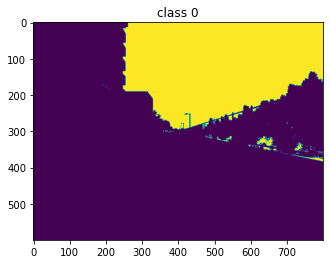

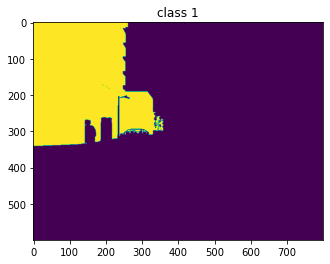

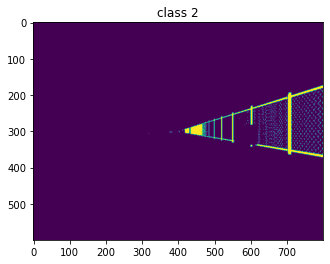

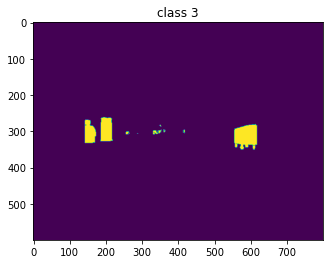

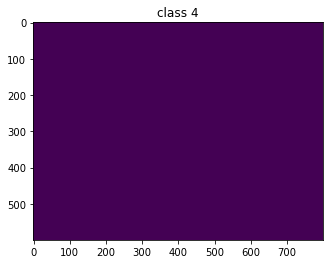

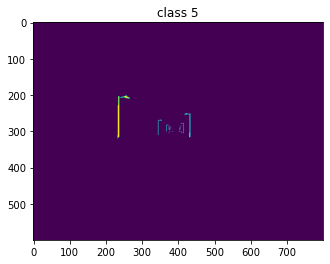

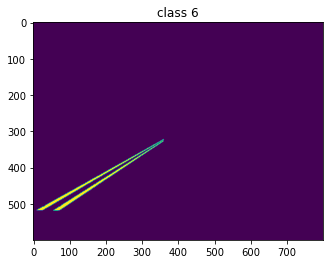

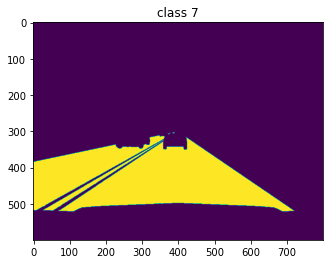

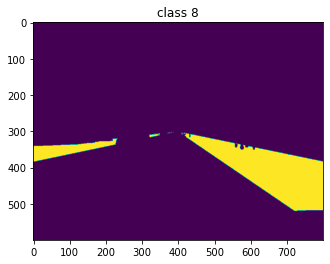

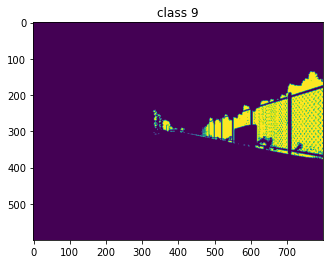

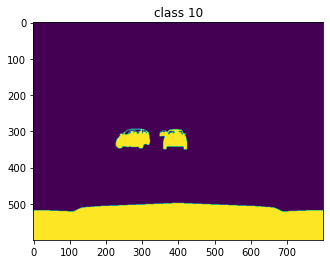

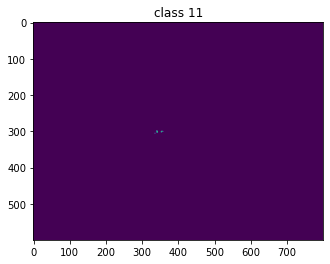

In [5]:
for i in range(12):
    mask = plt.imread('SS_Self_driving_Cars/dataA/dataA/CameraSeg/02_00_220.png')*255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    plt.title(f'class {i}')
    plt.imshow(mask)
    plt.show()

In [6]:
labels = ['Unlabeled','Building','Fence','Other',
                'Pedestrian', 'Pole', 'Roadline', 'Road',
                'Sidewalk', 'Vegetation', 'Car','Wall',
                 'Traffic sign']

In [7]:
def get_index_label_dictionary(labels):
    index_label_dictionary = {}
    for i, label in enumerate(labels):
        index_label_dictionary[i] = label
    return index_label_dictionary

get_index_label_dictionary(labels)

{0: 'Unlabeled',
 1: 'Building',
 2: 'Fence',
 3: 'Other',
 4: 'Pedestrian',
 5: 'Pole',
 6: 'Roadline',
 7: 'Road',
 8: 'Sidewalk',
 9: 'Vegetation',
 10: 'Car',
 11: 'Wall',
 12: 'Traffic sign'}

In [8]:
# разделим всё на два списка с rgb картинками и seg
cameraRGB = []
cameraSeg = []
for root, dirs, files in os.walk('SS_Self_driving_Cars'):
    for name in files:
        f = os.path.join(root, name)
        if 'CameraRGB' in f:
            cameraRGB.append(f)
        elif 'CameraSeg' in f:
            cameraSeg.append(f)
        else:
            break

In [9]:
len(cameraRGB)

5000

In [10]:
len(cameraSeg)

5000

In [11]:
df = pd.DataFrame({'cameraRGB': cameraRGB, 'cameraSeg': cameraSeg})
# Отсортируем датафрейм по значениям
df.sort_values(by='cameraRGB',inplace=True)
# Используем функцию, благодаря которой индексация значений будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые пять значений нашего датафрейма
print(df.head(5))

                                           cameraRGB  \
0  SS_Self_driving_Cars\dataA\dataA\CameraRGB\02_...   
1  SS_Self_driving_Cars\dataA\dataA\CameraRGB\02_...   
2  SS_Self_driving_Cars\dataA\dataA\CameraRGB\02_...   
3  SS_Self_driving_Cars\dataA\dataA\CameraRGB\02_...   
4  SS_Self_driving_Cars\dataA\dataA\CameraRGB\02_...   

                                           cameraSeg  
0  SS_Self_driving_Cars\dataA\dataA\CameraSeg\02_...  
1  SS_Self_driving_Cars\dataA\dataA\CameraSeg\02_...  
2  SS_Self_driving_Cars\dataA\dataA\CameraSeg\02_...  
3  SS_Self_driving_Cars\dataA\dataA\CameraSeg\02_...  
4  SS_Self_driving_Cars\dataA\dataA\CameraSeg\02_...  


In [12]:
df.cameraRGB[4999]

'SS_Self_driving_Cars\\dataE\\dataE\\CameraRGB\\F9-99.png'

In [13]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

In [14]:
# Создадим класс для кастомного датасета
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # Читаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
        
        # Упаковываем её в pytorch-тензор и оборачиваем ее в батч из одной картинки,
        # но при этом заполняем 13 каналов масками нужных классов
        # Т.е. там, где например класс автомобилей (10 по счету канал) - все пиксели 0 
        # если не принадлежат классу, и 1 если принадлежат 
        x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)
        for i in range(1, 12):
            mask = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
            mask = np.where(mask == i, 255, 0)
            x = torch.as_tensor(mask).unsqueeze(0)
            x_out =  torch.cat((x_out,x),dim=0)       
        x_out = x_out.float()
        
        lab = x_out.unsqueeze(0)
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=lab, size=256, mode='nearest')

        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [15]:
# Разделим датасет на тренировочную и тестовую выборки. И обернем их в наш кастомный класс.
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cameraRGB  3500 non-null   object
 1   cameraSeg  3500 non-null   object
dtypes: object(2)
memory usage: 54.8+ KB


In [17]:
# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data  = CustomDatasetFromImages(X_test)

# Теперь обернем то, что получилось, в даталоадеры:
train_data_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_data_loader  = DataLoader(test_data,  batch_size=1, shuffle=False)

In [18]:
train_data.__getitem__(7)[0].shape

torch.Size([1, 3, 256, 256])

In [19]:
train_data.__getitem__(7)[1].shape

torch.Size([1, 12, 256, 256])

In [20]:
# Обучение
learning_rate = 0.001
epochs = 5

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [22]:
# Определим нашу модель Unet для 12 классов:
Umodel = UNet(num_classes=12).to(device)

In [23]:
# Выберем оптимизирующую функцию и функцию потерь (целевая функция)
optimizer = torch.optim.Adam(Umodel.parameters(), lr=learning_rate)

class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = score.sum() / num
        return score

In [24]:
criterion = SoftDiceLoss()
# Определим количество шагов внутри одной эпохи
total_steps = len(train_data_loader)
print(f"{epochs} Epochs, {total_steps} Total_steps per epoch")

5 Epochs, 3500 Total_steps per epoch


In [25]:
# Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time
from torch.autograd import Variable

# Полезная функция для детектирования аномалий в процессе обучения
torch.autograd.set_detect_anomaly(True)

# Запускаем главный тренировочный цикл
epoch_losses = []
for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = Variable(data), Variable(labels)        
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = Umodel(data[0])

        loss = criterion(outputs, labels[0])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 300 == 299:
            print(f'Epoch: {epoch+1:2d}, Loss: {running_loss/300:.8f}')
            time2 = time.time()
            print(f'Spend time for 300 images: {time2-time1} sec')
            time1 = time.time()
            running_loss = 0.0
    
    print(f'Epoch {epoch+1:2d}, loss: {np.mean(epoch_loss):.8f}')
    epoch_losses.append(epoch_loss)

Epoch:  1, Loss: 0.04271806
Spend time for 300 images: 104.84999394416809 sec
Epoch:  1, Loss: 0.00154855
Spend time for 300 images: 100.7807765007019 sec
Epoch:  1, Loss: 0.00109439
Spend time for 300 images: 103.37323379516602 sec
Epoch:  1, Loss: 0.00100046
Spend time for 300 images: 108.15157723426819 sec
Epoch:  1, Loss: 0.00460274
Spend time for 300 images: 108.89520740509033 sec
Epoch:  1, Loss: 0.00021610
Spend time for 300 images: 108.83119750022888 sec
Epoch:  1, Loss: 0.00006834
Spend time for 300 images: 108.81369304656982 sec
Epoch:  1, Loss: 0.00006452
Spend time for 300 images: 108.85620164871216 sec
Epoch:  1, Loss: 0.00002438
Spend time for 300 images: 109.26377320289612 sec
Epoch:  1, Loss: 0.00005447
Spend time for 300 images: 109.235267162323 sec
Epoch:  1, Loss: 0.00028031
Spend time for 300 images: 109.38629531860352 sec
Epoch  1, loss: 0.00448991
Epoch:  2, Loss: 0.00008711
Spend time for 300 images: 107.42644882202148 sec
Epoch:  2, Loss: 0.00003383
Spend time f

In [27]:
torch.save(Umodel.state_dict(), './Unet.pth')

#### 2. Подготовка и обучение датасета https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks

In [43]:
path_img='./set-lipstick-original/720p/'
path_mask='./set-lipstick-original/mask/'
df_list=pd.read_csv('./set-lipstick-original/list.csv')

df_list['filename']=path_img+df_list['filename']
df_list['mask']=path_mask+df_list['mask']

In [44]:
df_list['is_files']=False
for dx in range(df_list.shape[0]):
    df_list['is_files'][dx]=(os.access(df_list['mask'][dx],os.F_OK) & os.access(df_list['filename'][dx],os.F_OK))
df_list=df_list[df_list['is_files']==True] 

C:\Users\samia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
df_list

,filename,width,height,class,xmin,ymin,xmax,ymax,mask,is_files
0,./set-lipstick-original/720p/image00000001.jpg,1280,720,Lips,661,394,776,444,./set-lipstick-original/mask/mask00000001.png,True
1,./set-lipstick-original/720p/image00000002.jpg,1280,720,Lips,557,336,682,392,./set-lipstick-original/mask/mask00000002.png,True
2,./set-lipstick-original/720p/image00000003.jpg,1280,720,Lips,553,369,684,427,./set-lipstick-original/mask/mask00000003.png,True
3,./set-lipstick-original/720p/image00000004.jpg,1280,720,Lips,555,351,681,408,./set-lipstick-original/mask/mask00000004.png,True
4,./set-lipstick-original/720p/image00000005.jpg,1280,720,Lips,555,351,680,407,./set-lipstick-original/mask/mask00000005.png,True
...,...,...,...,...,...,...,...,...,...,...
28589,./set-lipstick-original/720p/image00028590.jpg,1280,720,Lips,657,347,817,450,./set-lipstick-original/mask/mask00028590.png,True
28590,./set-lipstick-original/720p/image00028591.jpg,1280,720,Lips,713,325,884,388,./set-lipstick-original/mask/mask00028591.png,True
28591,./set-lipstick-original/720p/image00028592.jpg,1280,720,Lips,659,401,808,488,./set-lipstick-original/mask/mask00028592.png,True
28592,./set-lipstick-original/720p/image00028593.jpg,1280,720,Lips,689,334,839,431,./set-lipstick-original/mask/mask00028593.png,True


In [46]:
df = pd.DataFrame({'cameraRGB': df_list['filename'], 'cameraSeg': df_list['mask']})
# Отсортируем  датафрейм по значениям
df.sort_values(by='cameraRGB',inplace=True)
# Используем функцию,
# лагодаря которой индексация значений 
# будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые ять значений нашего датафрейма
print(df.head(5))

                                        cameraRGB  \
0  ./set-lipstick-original/720p/image00000001.jpg   
1  ./set-lipstick-original/720p/image00000002.jpg   
2  ./set-lipstick-original/720p/image00000003.jpg   
3  ./set-lipstick-original/720p/image00000004.jpg   
4  ./set-lipstick-original/720p/image00000005.jpg   

                                       cameraSeg  
0  ./set-lipstick-original/mask/mask00000001.png  
1  ./set-lipstick-original/mask/mask00000002.png  
2  ./set-lipstick-original/mask/mask00000003.png  
3  ./set-lipstick-original/mask/mask00000004.png  
4  ./set-lipstick-original/mask/mask00000005.png  


In [47]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=1,shuffle=False)

In [48]:
#!pip install segmentation_models_pytorch
#!pip install albumentations
import time
import segmentation_models_pytorch as smp

In [49]:
#data=torch.from_numpy(train_data_loader).float().to(device)
train_data.data_info

,cameraRGB,cameraSeg
0,./set-lipstick-original/720p/image00023774.jpg,./set-lipstick-original/mask/mask00023774.png
1,./set-lipstick-original/720p/image00027670.jpg,./set-lipstick-original/mask/mask00027670.png
2,./set-lipstick-original/720p/image00015328.jpg,./set-lipstick-original/mask/mask00015328.png
3,./set-lipstick-original/720p/image00022909.jpg,./set-lipstick-original/mask/mask00022909.png
4,./set-lipstick-original/720p/image00009859.jpg,./set-lipstick-original/mask/mask00009859.png
...,...,...
19973,./set-lipstick-original/720p/image00013281.jpg,./set-lipstick-original/mask/mask00013281.png
19974,./set-lipstick-original/720p/image00017174.jpg,./set-lipstick-original/mask/mask00017174.png
19975,./set-lipstick-original/720p/image00014040.jpg,./set-lipstick-original/mask/mask00014040.png
19976,./set-lipstick-original/720p/image00020028.jpg,./set-lipstick-original/mask/mask00020028.png


In [51]:
learning_rate = 0.001
epochs = 1

criterion = SoftDiceLoss()

total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")
# создание модели
model = smp.Unet('resnet34', encoder_weights = 'imagenet', classes=12, activation='sigmoid').to(device)
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=learning_rate)])
epoch_losses = []

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = []
    t = 0
    time1 = time.time()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs[0])
        loss = criterion(outputs,labels[0])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        t += 1
        if t % 500 == 499:    # print every 5000 mini-batches
            print(f'Epoch: {epoch+1:2d}, Batchcount: {t}, Avg. Loss: {running_loss/500:.8f}')
            running_loss = 0.0
            
    time2 = time.time()
    print(f'Epoch {epoch+1}, Loss: {np.mean(epoch_loss):.8f} Time = {time2-time1} sec')
    epoch_losses.append(epoch_loss)

1 epochs, 19978 total_steps per epoch
Epoch:  1, Batchcount: 499, Avg. Loss: 0.97934322
Epoch:  1, Batchcount: 999, Avg. Loss: 0.96822321
Epoch:  1, Batchcount: 1499, Avg. Loss: 0.96811155
Epoch:  1, Batchcount: 1999, Avg. Loss: 0.96803104
Epoch:  1, Batchcount: 2499, Avg. Loss: 0.96809339


IndexError: too many indices for array